In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os

from io import StringIO

parent_dir = os.path.relpath("../")

sys.path.append(parent_dir)

import api

from geopy.distance import geodesic

import datetime

import numpy as np


In [12]:
def fetch_data(endpoint):
    response = requests.get(endpoint)

    if response.status_code == 200:
        data = response.json() 

        if "station" in data: 
            df = pd.DataFrame(data["station"])
            return df
        else:
            print("Unexpected JSON structure:", data)
            return None
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [13]:
def get_distance(point1, point2):
    return geodesic(point1[::-1], point2[::-1]).meters

In [14]:
# Air Temperature Stations
endpoint = "https://opendata-download-metobs.smhi.se/api/version/latest/parameter/19.json"
df = fetch_data(endpoint=endpoint)
station_keys = df['key']
long_lat = list(zip(df['longitude'], df['latitude']))

from_date = '2020-01-01'
to_date = '2021-01-01'
pest = 'Bladfläcksvampar'
gradings_df = api.get_gradings(from_date=from_date, to_date=to_date)
gradings_df = api.sweref99tm_to_wgs84(gradings_df)
first_row = gradings_df.iloc[0]

# find the closest station to our df
to_find = first_row['longitud'], first_row['latitud']
print(to_find)

cl = []
for i, station in enumerate(station_keys):
    dist = get_distance(to_find, long_lat[i])
    cl.append((dist, station))

cl = sorted(cl, key=lambda x: x[0])

(14.040506069950833, 55.896711836081586)


In [15]:
# get temperature records for our station
def get_for_station(i):
    endpoint = f"https://opendata-download-metobs.smhi.se/api/version/1.0/parameter/19/station/{cl[i][1]}/period/corrected-archive/data.csv"
    ret = requests.get(endpoint)

    if ret.status_code == 200:
        data = pd.read_csv(StringIO(ret.text), on_bad_lines='skip')
        data.to_csv('station_data.csv')
        lines = None
        
        with open('station_data.csv', 'r') as file:
            lines = file.readlines()
        for line in lines:
            line.strip()

        ending_date = lines[-1].split(',')[1].split(';')[1].split(' ')[0]
        ending_date = ending_date.split('-')
        td = to_date.split('-')
        try:
            for i in range(len(td)):
                td[i] = int(td[i])
                ending_date[i] = int(ending_date[i])
        except:
            return None
        index = -1
        for i, line in enumerate(lines):
            if 'Från Datum Tid (UTC)' in line:
                index = i
                break
            
        lines = lines[index:] 

        head = lines[0].split(';')
        head[0] = head[0][2:]
        lines = lines[1:] 

        data = [line.split(';') for line in lines]  

        cleaned_data = []
        for d in data:
            idx = d[0].find(',')
            cleaned_line = d[0][idx+1:].split(';') 
            cleaned_data.append(cleaned_line + d[1:]) 
        
        data = cleaned_data

        df = pd.DataFrame(data, columns=head)  

        df.to_csv('station_data.csv', sep=';', index=False)


        if datetime.date(ending_date[0], ending_date[1], ending_date[2]) < datetime.date(td[0], td[1], td[2]):
            return None
        else:
            return i
 
    else:
        print(f"Error fetching data: {ret.status_code}")

get_for_station(0)

In [16]:
idx = None
for i in range(100):
    ret = get_for_station(i)
    if ret is not None:
        idx = i
        break

# data = pd.read_csv('station_data.csv', delimiter=';', on_bad_lines='skip')

In [17]:
data = pd.read_csv('station_data.csv', delimiter=';', on_bad_lines='skip') 
print(data['Lufttemperatur'])
print(data)

0       -11.0
1       -14.5
2       -11.5
3       -12.0
4        -6.0
         ... 
24880     8.2
24881     5.7
24882     9.9
24883    10.4
24884     7.2
Name: Lufttemperatur, Length: 24885, dtype: float64
      Från Datum Tid (UTC) Till Datum Tid (UTC) Representativt dygn  \
0      1940-12-31 18:00:01  1941-01-01 18:00:00          1941-01-01   
1      1941-01-01 18:00:01  1941-01-02 18:00:00          1941-01-02   
2      1941-01-02 18:00:01  1941-01-03 18:00:00          1941-01-03   
3      1941-01-03 18:00:01  1941-01-04 18:00:00          1941-01-04   
4      1941-01-04 18:00:01  1941-01-05 18:00:00          1941-01-05   
...                    ...                  ...                 ...   
24880  2024-10-26 18:00:01  2024-10-27 18:00:00          2024-10-27   
24881  2024-10-27 18:00:01  2024-10-28 18:00:00          2024-10-28   
24882  2024-10-28 18:00:01  2024-10-29 18:00:00          2024-10-29   
24883  2024-10-29 18:00:01  2024-10-30 18:00:00          2024-10-30   
24884  2024-1

In [38]:
def extract_pest(df: pd.DataFrame, pest: str) -> pd.DataFrame:
    """
    Look through df and extract data from 'graderingstillfalleList'.
    Extract records where 'skadegorare' == pest,
    Also adding other relevant information such as delomrade, lat-lon coordinates
    Needed since graderingslist is a list containing all measure instances for a given time period (year)
    """

    records = []

    for idx, row in df.iterrows():
        graderings_tillfallen = row.get('graderingstillfalleList', [])
        if not isinstance(graderings_tillfallen, list):
            continue

        #get area name, lat/long, etc
        delomrade_val = row.get('delomrade')
        lat_val = row.get('latitud')
        lon_val = row.get('longitud')
        crop = row.get('groda')
        sort = row.get('sort')

        for tillfalle in graderings_tillfallen:
            datum_str = tillfalle.get('graderingsdatum')
            datum_parsed = pd.to_datetime(datum_str, errors='coerce') if datum_str else None
            year = datum_parsed.year if pd.notnull(datum_parsed) else None

            graderingar = tillfalle.get('graderingList', [])
            for g in graderingar:
                if g.get('skadegorare') == pest:
                    varde_str = g.get('varde')
                    value = pd.to_numeric(varde_str, errors='coerce') if varde_str is not None else None
                    measuring_method = g.get('matmetod')

                    records.append({
                        "index_in_main_df": idx,
                        "delomrade": delomrade_val,
                        "latitud": lat_val,
                        "longitud": lon_val,
                        "date": datum_parsed,
                        "year": year,
                        "crop": crop,
                        "type": sort,
                        "pest": pest,
                        "measuring_method": measuring_method,
                        "value": value
                    })

    return pd.DataFrame(records)


df_bf = extract_pest(gradings_df.head(), 'Bladlus')
df_bf = df_bf.sort_values(by='date')

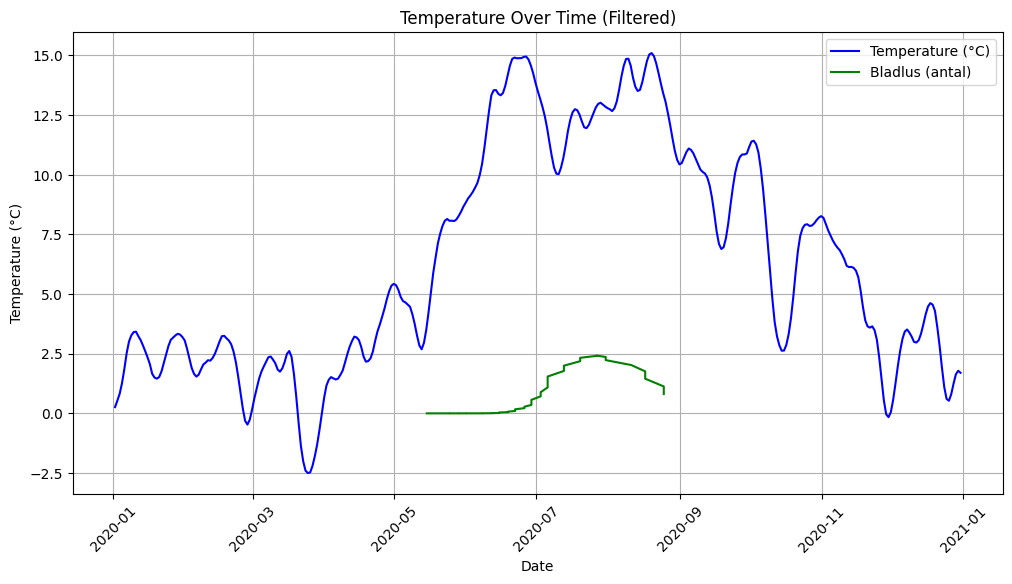

In [ ]:
data = pd.read_csv('station_data.csv', sep=';')

data['Från Datum Tid (UTC)'] = pd.to_datetime(data['Från Datum Tid (UTC)'], errors='coerce')
data['Till Datum Tid (UTC)'] = pd.to_datetime(data['Till Datum Tid (UTC)'], errors='coerce')

def normalize_features(X):
    for col in range(X.shape[1]):
        X[:, col] = (X[:, col] -  np.min(X[:, col] )) / (np.max(X[:, col] ) - np.min(X[:, col] ))
    return X

start_range = pd.to_datetime(from_date)
end_range = pd.to_datetime(to_date)

vector_size = 11
stddev = 2

weights = np.exp(-0.5 * (np.linspace(-stddev, stddev, vector_size) ** 2))
weights = weights / np.sum(weights)

smoothed_temperature = np.convolve(data['Lufttemperatur'], weights, mode='same')
data['Lufttemperatur'] = smoothed_temperature

smoothed_temperature = np.convolve(df_bf['value'], weights, mode='same')
df_bf['value'] = smoothed_temperature

filtered_data = data[(data['Från Datum Tid (UTC)'] >= start_range) & (data['Till Datum Tid (UTC)'] <= end_range)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Från Datum Tid (UTC)'], filtered_data['Lufttemperatur'], linestyle='-', color='b', label='Temperature (°C)')
plt.plot(df_bf['date'], df_bf['value'], color='g', label='Bladlus (antal)')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time (Filtered)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

#preproccesing, visual, in i api det som ska, fixa för windwos
